In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
%matplotlib inline

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import json

#Sequential model from Keras. 
#Linear stack of neural network layers, nice for the type of feed-forward CNN we're building.
from keras.models import Sequential

#Core layers of Keras, used in almost any neural network:
from keras.layers import Dense, Dropout, Activation, Flatten

#CNN layers of Keras. These are the convolutional layers that will help us efficiently train on image data.
from keras.layers import Convolution2D, MaxPooling2D

labeled_images = pd.read_csv('train.csv')
print(labeled_images.shape)

(42000, 785)


In [29]:
#Let's start with a set of 5000 images for speed concerns, and split out set between train and test.

images = labeled_images.iloc[0:5000,1:]
labels = labeled_images.iloc[0:5000,:1]

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, train_size=0.8, random_state=0)

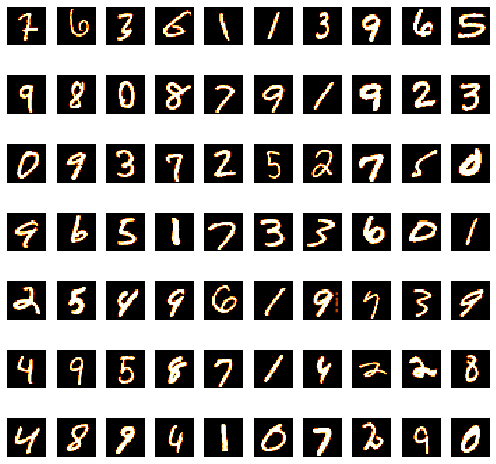

In [30]:
# Let's start by plotting some numbers

plt.figure(figsize=(7,7))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = X_train.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

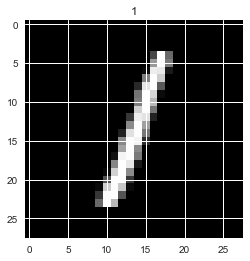

In [31]:
#Easy viz of images on gray (0-255) scale

i=5
img=X_train.iloc[i].as_matrix()
img=img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(Y_train.iloc[i,0])

(array([ 719.,    4.,    4.,    3.,    9.,    5.,    3.,    3.,    8.,   26.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

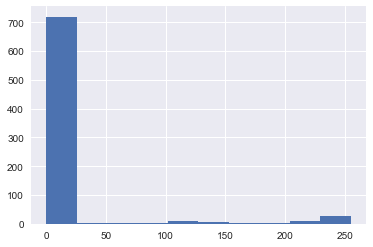

In [32]:
#Let's also plot the distribution of features' values.
plt.hist(X_train.iloc[i])

In [33]:
#Dimensionality reduction: 
# 1) Standardizing the data:

from sklearn.preprocessing import StandardScaler

def std_scaling(df):

    X = df.values
    X_std = StandardScaler().fit_transform(X)
    return X_std

X_std = std_scaling(X_train)
X_test_std = std_scaling(X_test)
    
# 2) Calculating Eigenvectors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# 3) Creating a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# 4) Sorting the eigenvalue, eigenvector pairs from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# 5) Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

C:\Users\Mehdi\Miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


C:\Users\Mehdi\Miniconda3\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


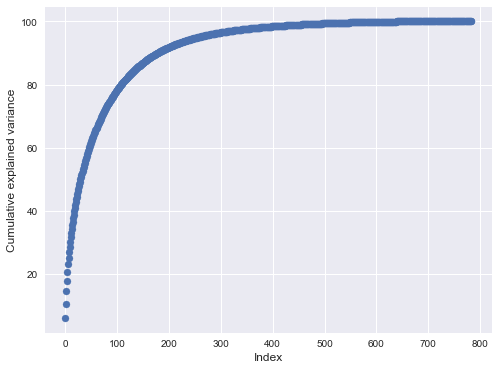


We can see above that we reach around 90% of explained variance with about 200 features.



In [34]:
# Plotting the cumulative explained variance, and use the insights to select the amount of features
#we want to keep.

plt.figure(figsize=(8,6))
plt.scatter(range(cum_var_exp.shape[0]), cum_var_exp)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)
plt.show()

print("""
We can see above that we reach around 90% of explained variance with about 200 features.
""")

In [35]:
# Visualizing the Eigenvalues
# As alluded to above, since the PCA method seeks to obtain the optimal directions (or eigenvectors) 
# that captures the most variance ( spreads out the data points the most ). Therefore it may be 
# informative (and cool) to visualise these directions and their associated eigenvalues. 

# For the purposes of this notebook and for speed, I will invoke PCA to only extract the top 30 
# eigenvalues ( using Sklearn's .components_ call) from the digit dataset and visually compare 
# the top 5 eigenvalues to some of the other smaller ones to see if we can glean any insights.

from sklearn.decomposition import PCA

# Invoke SKlearn's PCA method
n_components = 30
pca = PCA(n_components=n_components).fit(X_train.values)

eigenvalues = pca.components_.reshape(n_components, 28, 28)

# Extracting the PCA components ( eignevalues )
#eigenvalues = pca.components_.reshape(n_components, 28, 28)
eigenvalues = pca.components_

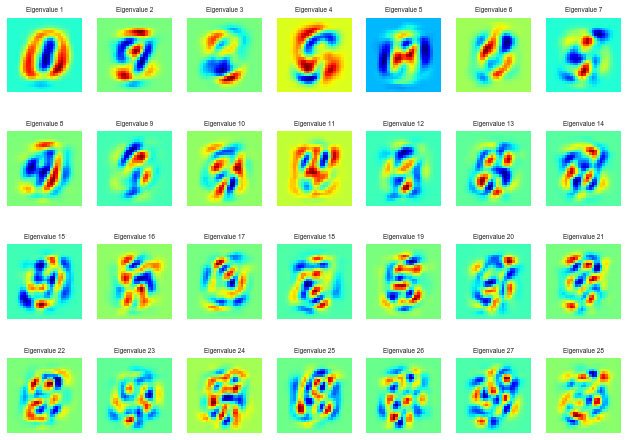


The subplots above portray the top 30 optimal directions or principal component axes that 
the PCA method has decided to generate for our digit dataset. Of interest is when one compares 
the first component "Eigenvalue 1" to the 28th component "Eigenvalue 28", it is obvious that 
more complicated directions or components are being generated in the search to maximise 
variance in the new feature subspace.




In [36]:
n_row = 4
n_col = 7

# Plot the first 28 eignenvalues

plt.figure(figsize=(11,8))

for i in list(range(n_row * n_col)):
    offset = 0
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(eigenvalues[i].reshape(28,28), cmap='jet')
    title_text = 'Eigenvalue ' + str(i + 1)
    plt.title(title_text, size=6.5)
    plt.xticks(())
    plt.yticks(())
plt.show()

print("""
The subplots above portray the top 30 optimal directions or principal component axes that 
the PCA method has decided to generate for our digit dataset. Of interest is when one compares 
the first component "Eigenvalue 1" to the 28th component "Eigenvalue 28", it is obvious that 
more complicated directions or components are being generated in the search to maximise 
variance in the new feature subspace.

""")

In [37]:
def pca_transform(df_std, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(df_std)
    df_transform = pca.transform(X_std)
    return df_transform

#PCA transform of features and one hot encoding of labels

#X_train = pca_transform(df_std=X_std, n_components=200)
#X_test = pca_transform(df_std=X_test_std, n_components=200)

#One-Hot encoding of labels

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


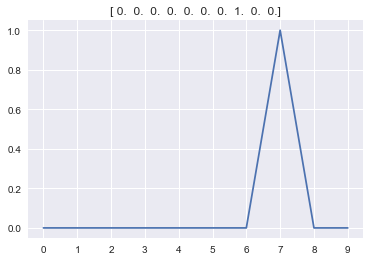

In [38]:
#Quick visual explanation of the labels encoding.

plt.title(Y_train[0])
plt.plot(Y_train[0])
plt.xticks(range(10));

print(Y_train[:5])

In [39]:
#Designing NN architecture

#Fixing random seed to ensure reproducibility

seed = 43
np.random.seed(seed)

print(X_train.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = X_train.values.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.values.reshape(X_test.shape[0], 1, 28, 28)

print(X_train.shape)

(4000, 784)
(4000, 1, 28, 28)


In [57]:
######### Model architecture #########

model = Sequential()

model.add(Convolution2D(32, kernel_size=(3,3), activation='relu', input_shape=(1,28,28), data_format='channels_first'))
model.add(Convolution2D(32, kernel_size=(3,3), activation='relu', data_format='channels_first'))

#CNN Layer.
#First 3 parameters? 
# - number of convolution filters to use.
# - kernels_size=number of rows and columns in each convolution kernel.

model.add(MaxPooling2D(pool_size=(2,2)))

#MaxPooling2D layer is a way to reduce the number of parameters in our model 
#by sliding a 2x2 pooling filter across the previous layer and taking 
#the max of the 4 values in the 2x2 filter.

model.add(Dropout(0.25))

#Dropout layer. 
#This is a method for regularizing our model in order to prevent overfitting.

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#For Dense layers, the first parameter is the output size of the layer. 
#Keras automatically handles the connections between layers.
#Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.

# Loss function and optimizer definition

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#To fit the model, all we have to do is declare the batch size and number of epochs to train for, 
#then pass in our training data.

model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)

#Finally, we can evaluate our model on the test data:
score = model.evaluate(X_test, Y_test, verbose=0)

C:\Users\Mehdi\Miniconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
4000/4000 [==============================] - 26s - loss: 0.8135 - acc: 0.7352    
Epoch 2/10
4000/4000 [==============================] - 26s - loss: 0.3204 - acc: 0.8962    
Epoch 3/10
4000/4000 [==============================] - 26s - loss: 0.2271 - acc: 0.9323    
Epoch 4/10
4000/4000 [==============================] - 25s - loss: 0.1693 - acc: 0.9472    
Epoch 5/10
4000/4000 [==============================] - 27s - loss: 0.1327 - acc: 0.9610    
Epoch 6/10
4000/4000 [==============================] - 28s - loss: 0.1249 - acc: 0.9610    
Epoch 7/10
4000/4000 [==============================] - 27s - loss: 0.0962 - acc: 0.9710    
Epoch 8/10
4000/4000 [==============================] - 27s - loss: 0.0856 - acc: 0.9732    
Epoch 9/10
4000/4000 [==============================] - 27s - loss: 0.0769 - acc: 0.9735    
Epoch 10/10
4000/4000 [==============================] - 26s - loss: 0.0733 - acc: 0.9768    
